<a href="https://colab.research.google.com/github/ddroder/student_alcohol_consumption_analysis/blob/master/student_alcohol_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pandas
!pip3 install tensorflow
!pip3 install fbprophet
!pip3 install numpy
!pip install seaborn
!pip install matplotlib
!pip3 install h2o
!pip3 install math
!pip3 install sklearn

     |████████████████████████████████| 123.6MB 1.3MB/s 
  Created wheel for h2o: filename=h2o-3.26.0.6-py2.py3-none-any.whl size=123690782 sha256=fc362996fb06abc1e94a80c68e567ea89d34c23361ac4e514f1ad74e22825ad2
  Stored in directory: /root/.cache/pip/wheels/eb/1a/72/252857fc093eaad70a7f91ddbcabf1dafd38fb5e6c02bcf9b3
Successfully built h2o
  ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from fbprophet import Prophet
import h2o
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.preprocessing import OneHotEncoder

In [0]:
!ls 'drive/My Drive/student-por.csv'

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
math = pd.read_csv('drive/My Drive/student-mat.csv')
por = pd.read_csv('drive/My Drive/student-por.csv')
joined = math.append(por)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


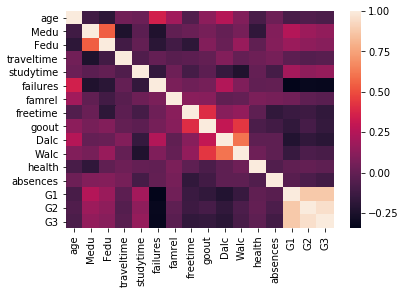

In [5]:
def absence_heatmap(): 
    high_absence = joined.loc[joined['absences'] > 8]
    corr = high_absence.corr()
    test = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, annot = False)
    return test
absence_heatmap()

Text(0.5, 0, 'Weekly alcohol consumption')

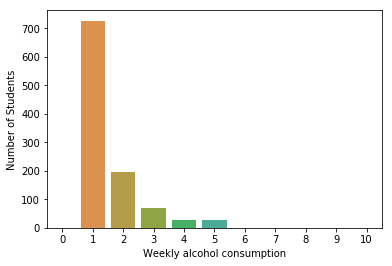

In [6]:
list = []
for i in range(11):
    list.append(len(joined[joined.Dalc == i]))
ax = sns.barplot(x = [0,1,2,3,4,5,6,7,8,9,10], y = list)
plt.ylabel('Number of Students')
plt.xlabel('Weekly alcohol consumption')

Text(0.5, 0, 'Students grade distribution according to weekly alcohol consumption')

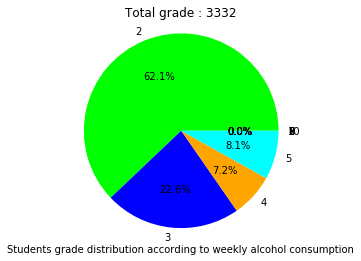

In [0]:
labels = ['2','3','4','5','6','7','8','9','10']
colors = ['lime','blue','orange','cyan','grey','purple','brown','red','darksalmon']
explode = [0,0,0,0,0,0,0,0,0]
sizes = []
for i in range(2,11):
    sizes.append(sum(joined[joined.Dalc == i].G3))
total_grade = sum(sizes)
average = total_grade/float(len(joined))
plt.pie(sizes,explode=explode,colors=colors,labels=labels,autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Total grade : '+str(total_grade))
plt.xlabel('Students grade distribution according to weekly alcohol consumption')

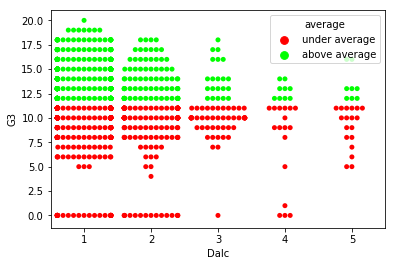

In [0]:
ave = sum(joined.G3)/float(len(joined))
joined['ave_line'] = ave
joined['average'] = ['above average' if i > ave else 'under average' for i in joined.G3]
sns.swarmplot(x='Dalc', y = 'G3', hue = 'average',data= joined,palette={'above average':'lime', 'under average': 'red'})

In [9]:
merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = joined.duplicated(keep=False, subset=merge_vector)
duplicated_df = joined[duplicated_mask]
unique_df = joined[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

In [0]:
def encode(series): 
  return pd.get_dummies(series.astype(str))

In [0]:
train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)

train_y = encode(students_df.drinker)

In [0]:
train_size = 0.85

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [0]:
def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [0]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

In [0]:
training_epochs = 5001
display_step = 1000
batch_size = 64

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [0]:
predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.735
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 60.170945785
Epoch: 1001 cost= 0.235076865
Epoch: 2001 cost= 0.075472759


In [16]:
train_x.head()
train_y.head()

,no,yes
220,1,0
254,0,1
156,0,1
224,1,0
407,1,0


In [53]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Import a sample binary outcome train/test set into H2O
#math = pd.read_csv('drive/My Drive/student-mat.csv')
#por = pd.read_csv('drive/My Drive/student-por.csv')
#joined = math.append(por)
x = students_df.columns.values.tolist()
y = "drinker"
students_df.to_csv('students_df.csv')
data = h2o.import_file("students_df.csv")
train,test,valid = data.split_frame(ratios = [.75,.20])
print(train)
# Identify predictors and response
print(type(x))
print(type(y))
x = x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,28 mins 53 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_unknownUser_jo9gzi
H2O cluster total nodes:,1
H2O cluster free memory:,2.917 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,Dalc,Fedu,Fjob,G1,G2,G3,Medu,Mjob,Pstatus,Walc,absences,activities,address,age,course,failures,famrel,famsize,famsup,freetime,goout,guardian,health,higher,internet,nursery,paid,reason,romantic,school,schoolsup,sex,studytime,traveltime,alcohol,drinker
220,1,1,services,6,6,6,2,at_home,T,2,2,yes,R,17,both,0,4,GT3,yes,2,5,mother,5,yes,yes,yes,no,reputation,no,GP,no,F,2,2,2,no
156,3,2,other,16,12,13,1,other,T,3,8,no,R,17,both,0,2,LE3,no,2,2,mother,5,yes,no,yes,no,reputation,no,GP,no,M,1,1,3,yes
224,1,4,services,13,13,14,4,teacher,T,1,0,yes,U,16,both,0,5,GT3,yes,3,2,mother,5,yes,yes,no,no,home,no,GP,no,F,3,1,1,no
407,1,4,other,9,12,12,4,other,T,1,0,yes,U,21,,2,3,LE3,no,3,2,other,5,yes,yes,yes,yes,reputation,no,GP,no,F,3,1,1,no
94,1,2,health,11,13,14,2,services,T,1,6,yes,U,15,both,0,4,LE3,yes,3,4,mother,4,yes,yes,yes,no,reputation,no,GP,no,M,4,1,1,no
292,1,1,at_home,12,12,13,2,services,T,1,12,no,U,18,,1,5,LE3,no,4,3,mother,5,yes,yes,yes,no,reputation,yes,GP,no,F,2,1,1,no
102,1,4,other,10,13,14,4,services,T,1,4,yes,U,15,both,0,5,GT3,yes,3,3,mother,5,yes,yes,no,no,course,no,GP,no,M,1,1,1,no
175,1,2,other,7,6,8,3,other,T,4,4,no,R,17,,2,4,GT3,yes,4,4,mother,3,yes,yes,yes,no,course,yes,GP,yes,M,2,2,2,no
457,5,2,services,10,11,11,1,at_home,T,5,4,yes,R,17,,0,5,LE3,yes,5,5,mother,3,yes,yes,yes,no,reputation,no,MS,no,M,1,1,5,yes
342,1,4,other,16,15,15,3,services,T,3,11,yes,U,18,both,0,4,LE3,no,3,3,mother,5,yes,yes,yes,no,home,yes,GP,no,M,2,1,2,no



<class 'list'>
<class 'str'>
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191006_051340,1,0.000673681,0,0.00106867,1.14206e-06
GBM_grid_1_AutoML_20191006_051340_model_1,1,0,0,0,0
XGBoost_1_AutoML_20191006_051340,1,0.0435511,0,0.056757,0.00322135
XGBoost_grid_1_AutoML_20191006_051340_model_2,1,0.00015102,0,0.000717625,5.14986e-07
XGBoost_grid_1_AutoML_20191006_051340_model_3,1,0.0264101,0,0.0347732,0.00120918
StackedEnsemble_BestOfFamily_AutoML_20191006_051340,1,0.00114387,0,0.00262588,6.89522e-06
GBM_4_AutoML_20191006_051340,1,2.76566e-16,0,3.04566e-15,9.27605e-30
XRT_1_AutoML_20191006_051340,1,0.0607939,0,0.0898192,0.00806749
XGBoost_2_AutoML_20191006_051340,1,0.101134,0,0.120404,0.0144971
GBM_3_AutoML_20191006_051340,1,6.59538e-17,0,6.29124e-16,3.95797e-31


In [54]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191006_051340

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 2.3449166624873357e-07
RMSE: 0.00048424339566867976
LogLoss: 0.00041456596477932055
Null degrees of freedom: 504
Residual degrees of freedom: 484
Null deviance: 573.9213774136011
Residual deviance: 0.4187116244271142
AIC: 42.41871162442711
AUC: 1.0
pr_auc: 0.9922480620155039
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9964669587214745: 


,,no,yes,Error,Rate
0,no,376.0,0.0,0.0,(0.0/376.0)
1,yes,0.0,129.0,0.0,(0.0/129.0)
2,Total,376.0,129.0,0.0,(0.0/505.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.996467,1.000000,126.0
1,max f2,0.996467,1.000000,126.0
2,max f0point5,0.996467,1.000000,126.0
3,max accuracy,0.996467,1.000000,126.0
4,max precision,0.999433,1.000000,0.0
5,max recall,0.996467,1.000000,126.0
6,max specificity,0.999433,1.000000,0.0
7,max absolute_mcc,0.996467,1.000000,126.0
8,max min_per_class_accuracy,0.996467,1.000000,126.0
9,max mean_per_class_accuracy,0.996467,1.000000,126.0



Gains/Lift Table: Avg response rate: 25.54 %, avg score: 25.55 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011881,0.999427,3.914729,3.914729,1.00000,0.999430,1.000000,0.999430,0.046512,0.046512,291.472868,291.472868
1,,2,0.021782,0.999425,3.914729,3.914729,1.00000,0.999426,1.000000,0.999428,0.038760,0.085271,291.472868,291.472868
2,,3,0.031683,0.999417,3.914729,3.914729,1.00000,0.999421,1.000000,0.999426,0.038760,0.124031,291.472868,291.472868
3,,4,0.041584,0.999414,3.914729,3.914729,1.00000,0.999415,1.000000,0.999423,0.038760,0.162791,291.472868,291.472868
4,,5,0.051485,0.999411,3.914729,3.914729,1.00000,0.999412,1.000000,0.999421,0.038760,0.201550,291.472868,291.472868
5,,6,0.100990,0.999390,3.914729,3.914729,1.00000,0.999401,1.000000,0.999411,0.193798,0.395349,291.472868,291.472868
6,,7,0.150495,0.999361,3.914729,3.914729,1.00000,0.999376,1.000000,0.999399,0.193798,0.589147,291.472868,291.472868
7,,8,0.200000,0.999292,3.914729,3.914729,1.00000,0.999331,1.000000,0.999383,0.193798,0.782946,291.472868,291.472868
8,,9,0.300990,0.000383,2.149263,3.322368,0.54902,0.548611,0.848684,0.848137,0.217054,1.000000,114.926281,232.236842
9,,10,0.400000,0.000331,0.000000,2.500000,0.00000,0.000350,0.638614,0.638289,0.000000,1.000000,-100.000000,150.000000




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1.1420622749253805e-06
RMSE: 0.0010686731375520676
LogLoss: 0.0006736807297974511
Null degrees of freedom: 504
Residual degrees of freedom: 484
Null deviance: 574.2756884171673
Residual deviance: 0.6804175370954236
AIC: 42.68041753709542
AUC: 1.0
pr_auc: 0.9922480620155039
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9880530678847569: 


,,no,yes,Error,Rate
0,no,376.0,0.0,0.0,(0.0/376.0)
1,yes,0.0,129.0,0.0,(0.0/129.0)
2,Total,376.0,129.0,0.0,(0.0/505.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.988053,1.000000,124.0
1,max f2,0.988053,1.000000,124.0
2,max f0point5,0.988053,1.000000,124.0
3,max accuracy,0.988053,1.000000,124.0
4,max precision,0.999236,1.000000,0.0
5,max recall,0.988053,1.000000,124.0
6,max specificity,0.999236,1.000000,0.0
7,max absolute_mcc,0.988053,1.000000,124.0
8,max min_per_class_accuracy,0.988053,1.000000,124.0
9,max mean_per_class_accuracy,0.988053,1.000000,124.0



Gains/Lift Table: Avg response rate: 25.54 %, avg score: 25.54 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011881,0.999204,3.914729,3.914729,1.00000,0.999223,1.000000,0.999223,0.046512,0.046512,291.472868,291.472868
1,,2,0.021782,0.999179,3.914729,3.914729,1.00000,0.999187,1.000000,0.999206,0.038760,0.085271,291.472868,291.472868
2,,3,0.031683,0.999162,3.914729,3.914729,1.00000,0.999170,1.000000,0.999195,0.038760,0.124031,291.472868,291.472868
3,,4,0.041584,0.999150,3.914729,3.914729,1.00000,0.999156,1.000000,0.999186,0.038760,0.162791,291.472868,291.472868
4,,5,0.051485,0.999141,3.914729,3.914729,1.00000,0.999146,1.000000,0.999178,0.038760,0.201550,291.472868,291.472868
5,,6,0.100990,0.999084,3.914729,3.914729,1.00000,0.999112,1.000000,0.999146,0.193798,0.395349,291.472868,291.472868
6,,7,0.150495,0.998983,3.914729,3.914729,1.00000,0.999026,1.000000,0.999106,0.193798,0.589147,291.472868,291.472868
7,,8,0.200000,0.998806,3.914729,3.914729,1.00000,0.998907,1.000000,0.999057,0.193798,0.782946,291.472868,291.472868
8,,9,0.300990,0.000635,2.149263,3.322368,0.54902,0.547998,0.848684,0.847715,0.217054,1.000000,114.926281,232.236842
9,,10,0.400000,0.000465,0.000000,2.500000,0.00000,0.000523,0.638614,0.638014,0.000000,1.000000,-100.000000,150.000000


In [66]:
preds = aml.leader.predict(test)
perf = aml.leader.model_performance(test)
perf

stackedensemble prediction progress: |████████████████████████████████████| 100%

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 3.6018377518389156e-07
RMSE: 0.000600153126446819
LogLoss: 0.00046982632180070393
Null degrees of freedom: 119
Residual degrees of freedom: 99
Null deviance: 132.83967947614855
Residual deviance: 0.11275831723216782
AIC: 42.11275831723217
AUC: 1.0
pr_auc: 0.9655172413793103
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9966394583340941: 


,,no,yes,Error,Rate
0,no,91.0,0.0,0.0,(0.0/91.0)
1,yes,0.0,29.0,0.0,(0.0/29.0)
2,Total,91.0,29.0,0.0,(0.0/120.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.996639,1.000000,28.0
1,max f2,0.996639,1.000000,28.0
2,max f0point5,0.996639,1.000000,28.0
3,max accuracy,0.996639,1.000000,28.0
4,max precision,0.999409,1.000000,0.0
5,max recall,0.996639,1.000000,28.0
6,max specificity,0.999409,1.000000,0.0
7,max absolute_mcc,0.996639,1.000000,28.0
8,max min_per_class_accuracy,0.996639,1.000000,28.0
9,max mean_per_class_accuracy,0.996639,1.000000,28.0



Gains/Lift Table: Avg response rate: 24.17 %, avg score: 24.17 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.016667,0.999402,4.137931,4.137931,1.000000,0.999405,1.000000,0.999405,0.068966,0.068966,313.793103,313.793103
1,,2,0.025000,0.999401,4.137931,4.137931,1.000000,0.999402,1.000000,0.999404,0.034483,0.103448,313.793103,313.793103
2,,3,0.033333,0.999398,4.137931,4.137931,1.000000,0.999400,1.000000,0.999403,0.034483,0.137931,313.793103,313.793103
3,,4,0.041667,0.999382,4.137931,4.137931,1.000000,0.999397,1.000000,0.999402,0.034483,0.172414,313.793103,313.793103
4,,5,0.050000,0.999365,4.137931,4.137931,1.000000,0.999378,1.000000,0.999398,0.034483,0.206897,313.793103,313.793103
5,,6,0.100000,0.999304,4.137931,4.137931,1.000000,0.999340,1.000000,0.999369,0.206897,0.413793,313.793103,313.793103
6,,7,0.150000,0.999243,4.137931,4.137931,1.000000,0.999281,1.000000,0.999340,0.206897,0.620690,313.793103,313.793103
7,,8,0.200000,0.999128,4.137931,4.137931,1.000000,0.999198,1.000000,0.999304,0.206897,0.827586,313.793103,313.793103
8,,9,0.300000,0.000442,1.724138,3.333333,0.416667,0.416253,0.805556,0.804954,0.172414,1.000000,72.413793,233.333333
9,,10,0.400000,0.000374,0.000000,2.500000,0.000000,0.000405,0.604167,0.603817,0.000000,1.000000,-100.000000,150.000000
